# Model Implementation for 3D Cell Tracking


In [16]:
# !pip install torchsummary 
# !pip install gunpowder
# !pip install zarr
# !pip install matplotlib
# pip install tensorboard

In [11]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import random 
import matplotlib.pyplot as plt
from torchvision import models
from torchsummary import summary

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gunpowder as gp
import zarr
import math
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import skimage
import networkx
import pathlib
from tifffile import imread, imwrite
import tensorboard

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data Importing

## Extract Centroids

In [2]:
# function to convert 'TRA' channel into cell and frame-wise centroid positions
## Function to extract trajectories from data

base_path = pathlib.Path("/mnt/shared/celltracking/data/cho/")


# read parent-child links from file
links = np.loadtxt(base_path / "01_GT/TRA" / "man_track.txt", dtype=int)

# read annotated image stack
centroids = np.stack([imread(xi) for xi in sorted((base_path / "01_GT/TRA").glob("*.tif"))])  # images

# extract centroids from annotated image stacks
centers = skimage.measure.regionprops(centroids[0,0,:,:])
tracks = []
for t, frame in enumerate(centroids):
    centers = skimage.measure.regionprops(frame)
    for c in centers:
        tracks.append([c.label, t, int(c.centroid[1]), int(c.centroid[2])])
        
# constructs graph 
tracks = np.array(tracks)
graph = networkx.DiGraph()
for cell_id, t, x, y in tracks:
    graph.add_node((cell_id,t), x=x, y=y, t=t)
    
for cell_id, t in graph.nodes():
    if (cell_id, t+1) in graph.nodes():
        graph.add_edge((cell_id, t), (cell_id,t+1))

for child_id, child_from, _, child_parent_id in links:
    for parent_id, _, parent_to, _ in links:
        if child_parent_id == parent_id:
            graph.add_edge((parent_id, parent_to), (child_id, child_from))
            
# extract trajectories from graph set
tracks = [graph.subgraph(c) for c in networkx.weakly_connected_components(graph) if len(c)>0]

# remove tracks with 0 edges
tracks = [track for track in tracks if len(track.edges)>0]

## Define function to make image pairs

In [3]:
class getPaired(gp.BatchFilter):

    def __init__(self, raw, raw_shift, tracks, paired=True):
        self.raw = raw
        self.raw_shift = raw_shift
        self.tracks = tracks
        self.paired = paired
    
    # _ref channel array is stored in raw_ref, while second volume in pair will be stored raw_new
    def prepare(self, request):
        # obtain volume coordinates from tracks                
        deps = gp.BatchRequest()
        vol1,vol2 = self.sampler(request)
                
        deps[self.raw] = gp.ArraySpec(roi=gp.Roi(vol1,request[self.raw].roi.get_shape()))
        deps[self.raw_shift] = gp.ArraySpec(roi=gp.Roi(vol2,request[self.raw_shift].roi.get_shape()))

        return deps
    
    # required to inform downstream nodes about new array 
    def process(self, batch, request):
        # create a new batch to hold the new array
        out_batch = gp.Batch()

        # create new array and store it in the batch
        out_batch[self.raw_shift] = batch[self.raw_shift]
        out_batch[self.raw] = batch[self.raw]
        
        #print(f'raw: {batch[self.raw].spec.roi}')
        #print(batch[self.raw_shift].spec.roi)
        
        # make sure that coordinates for batch[raw] and batch[raw_shift] are reset to (0,0,0,0,0)
        out_batch[self.raw].spec.roi = request[self.raw].roi
        out_batch[self.raw_shift].spec.roi = request[self.raw_shift].roi

        # return the new batch
        return out_batch
    
    # select pairs of subvolumes from data
    def sampler(self,request):
        tracks = self.tracks
        paired = self.paired
        # choose connected nodes
        # if self.paired:
        if paired:
            t0 = tracks[np.random.randint(0,len(tracks),1).item()]
            e0 = list(t0.edges)[np.random.randint(len(list(t0.edges)))]
            node0 = t0.nodes[e0[0]]
            node1 = t0.nodes[e0[1]]
            
        # choose random unconnected nodes
        else:
            # randomly choose two tracks and make sure they are not identical
            t0,t1 = np.random.randint(0,len(tracks),2)
            while t0==t1:
                t0,t1 = np.random.randint(0,len(tracks),2)

            #print(f'trackids: {t0,t1}')
            t0 = tracks[t0]
            t1 = tracks[t1]

            # choose random edges from each track
            #print(f'number edges per track{len(list(t0.nodes)),len(list(t1.nodes))}')

            r0 = np.random.randint(0,len(list(t0.nodes))) 
            r1 = np.random.randint(0,len(list(t1.nodes)))

            node0 = t0.nodes[list(t0.nodes)[r0]]
            node1 = t1.nodes[list(t1.nodes)[r1]]
            


        node0_xyt = [node0["x"], node0["y"], node0["t"]]
        node1_xyt = [node1["x"], node1["y"], node1["t"]]

        #print(f'input coord: {node0_xyt,node1_xyt}')

        roi_in = request[self.raw_shift].roi.get_shape()
        #t,z,y,x
        coords_vol0 = (node0_xyt[2],0,node0_xyt[0]-(roi_in[2]/2),node0_xyt[1]-(roi_in[3]/2))
        coords_vol1 = (node1_xyt[2],0,node1_xyt[0]-(roi_in[2]/2),node1_xyt[1]-(roi_in[3]/2))
        #print(f'output coords - vol0: {coords_vol0}, vol1:{coords_vol1}')

        return coords_vol0, coords_vol1
            

# Make batches 

(1, 5, 64, 64)


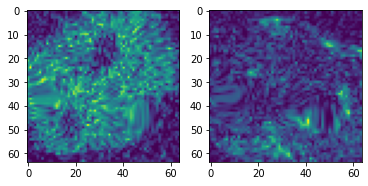

In [32]:
#specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = (0,0,0,0)
batch_size = 4

zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'
raw = gp.ArrayKey('raw')
raw_shift = gp.ArrayKey('raw_shift')

# create "pipeline" consisting only of a data source


#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

pipeline_paired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    )+ gp.Normalize(raw)+gp.Normalize(raw_shift)+ 
    gp.Pad(raw_shift, None) + 
    gp.Pad(raw, None) + gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw, mode="gaussian")) + gp.IntensityAugment(
    raw_shift,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw_shift, mode="gaussian") + getPaired(raw,raw_shift,tracks,paired=True) + gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25) + gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[])



pipeline_unpaired = (gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw_shift: 'raw', raw: 'raw'},  # which dataset to associate to the array key
    {raw_shift: gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True), raw:gp.ArraySpec(voxel_size=(1,1,1,1), interpolatable=True)}  # meta-information
    )+ gp.Normalize(raw)+gp.Normalize(raw_shift)+ 
    gp.Pad(raw_shift, None) + 
    gp.Pad(raw, None) + gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw, mode="gaussian") + gp.IntensityAugment(
    raw_shift,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    ) + gp.NoiseAugment(raw_shift, mode="gaussian")) + getPaired(raw,raw_shift,tracks,paired=False)  + gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25) + gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[]) 

pipeline_paired += gp.PreCache(num_workers=6) 
pipeline_unpaired += gp.PreCache(num_workers=6)
pipeline_paired += gp.Stack(batch_size)
pipeline_unpaired += gp.Stack(batch_size)

# specify request
request = gp.BatchRequest()
request[raw] = gp.Roi(coord, volSize)
request[raw_shift] = gp.Roi(coord, volSize)

gp.ArraySpec()
# build the pipeline...
# with gp.build(pipeline_paired), gp.build(pipeline_unpaired):

  # ...and request a batch
  # batch = pipeline_unpaired.request_batch(request)
  
#show the content of the batch
#print(f"batch returned: {batch}")

# plot first slice of volume
fig, axs = plt.subplots(1,2)
print(batch[raw].data.shape)
axs[0].imshow(np.flipud(batch[raw].data[0,0,:,:]))
axs[1].imshow(np.flipud(batch[raw_shift].data[0,0,:,:]))



In [5]:
# provide path to zarr directory
zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

data = zarr.open(zarrdir)
loader = []

## Define Augmentation pipeline

In [6]:
# provide path to zarr directory
#zarrdir = '/mnt/shared/celltracking/data/cho/01.zarr'

# pre-selected volumes from cho dataset
coord_paired = ((0,0,80, 175),(1,0,80, 180))
coord_unpaired = ((0,0,80, 175),(1,0,92, 232))

# specify subvolume size and volume source
volSize = (1,5,64, 64)
coord = coord_paired[0]

# declare arrays to use in the pipeline
key ='raw'
raw = gp.ArrayKey(key)

# create "pipeline" consisting only of a data source
source = gp.ZarrSource(
    zarrdir,  # the zarr container
    {raw: key},  # which dataset to associate to the array key
    {raw: gp.ArraySpec(interpolatable=True, voxel_size = (1,1,1,1))}  # meta-information
)
pipeline = source

# specify request paired
request_vol1p = gp.BatchRequest()
request_vol2p = gp.BatchRequest()
request_vol1p[raw] = gp.Roi(coord_paired[0], volSize)
request_vol2p[raw] = gp.Roi(coord_paired[1], volSize)

# specify request unpaired
request_vol1u = gp.BatchRequest()
request_vol2u = gp.BatchRequest()
request_vol1u[raw] = gp.Roi(coord_unpaired[0], volSize)
request_vol2u[raw] = gp.Roi(coord_unpaired[1], volSize)

# build the pipeline
with gp.build(pipeline):
    batch_vol1p = pipeline.request_batch(request_vol1p)
    batch_vol2p = pipeline.request_batch(request_vol2p)
    batch_vol1u = pipeline.request_batch(request_vol1u)
    batch_vol2u = pipeline.request_batch(request_vol2u)

# Augmentations

In [7]:
#Augmentations=

# chose a random source (i.e., sample) from the above
#random_location = gp.RandomLocation()

# elastically deform the batch
Elastic_augment=gp.ElasticAugment(
    [2,10,10],
    [0,2,2],
    [0,0*math.pi/2.0],
    prob_slip=0.05,
    prob_shift=0.05,
    max_misalign=25)

# apply transpose and mirror augmentations
# Simple_augment=gp.SimpleAugment(transpose_only=[2, 3], mirror_only=[]) 
Simple_augment=gp.SimpleAugment(transpose_only=[], mirror_only=[])

# scale and shift the intensity of the raw array
Intensity_augment=gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1,
    )

Noise_augment = gp.NoiseAugment(raw, mode="gaussian")

pipeline = (
    source + gp.Normalize(raw)+
            Intensity_augment+Elastic_augment + Simple_augment + Noise_augment
           )

# build the pipeline
with gp.build(pipeline):
    for x in range(10):
        batch_vol1p = pipeline.request_batch(request_vol1p)
        batch_vol2p = pipeline.request_batch(request_vol2p)
        batch_vol1u = pipeline.request_batch(request_vol1u)
        batch_vol2u = pipeline.request_batch(request_vol2u)
        # show the content of the batch
        #print(f"batch returned: {batch}")

        # plot first slice of volume

        # fig, (ax1, ax2) = plt.subplots(1, 2)
        # ax1.imshow(np.flipud(batch_vol1p[raw].data[0,1,:,:]))
        # ax2.imshow(np.flipud(batch_vol2p[raw].data[0,1,:,:]))
        # plt.show()


In [8]:
# specify request 
#plt.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))

# request = gp.BatchRequest()
# request[raw] = gp.Roi(coord, volSize)

# with gp.build(pipeline):
#     batch_vol1_aug = pipeline.request_batch(request)
#     batch_vol2_aug = pipeline.request_batch(request)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
# ax1.imshow(np.flipud(batch_vol1[raw].data[0,0,:,:]))
# ax1.set_title('input vol1')
# ax2.imshow(np.flipud(batch_vol1_aug[raw].data[0,0,:,:]))
# ax2.set_title('aug vol1')
# ax3.imshow(np.flipud(batch_vol2[raw].data[0,0,:,:]))
# ax3.set_title('input vol2')
# ax4.imshow(np.flipud(batch_vol2_aug[raw].data[0,0,:,:]))
# ax4.set_title('aug vol2')

# Define the Model

In [9]:
class Vgg3D(torch.nn.Module):

    def __init__(self, input_size, output_classes, downsample_factors, fmaps=12):

        super(Vgg3D, self).__init__()

        self.input_size = input_size
        self.downsample_factors = downsample_factors
        self.output_classes = 2

        current_fmaps, h, w, d = tuple(input_size)
        current_size = (h, w,d)

        features = []
        for i in range(len(downsample_factors)):

            features += [
                torch.nn.Conv3d(current_fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv3d(fmaps,fmaps,kernel_size=3,padding=1),
                torch.nn.BatchNorm3d(fmaps),
                torch.nn.ReLU(inplace=True),
                torch.nn.MaxPool3d(downsample_factors[i])
            ]

            current_fmaps = fmaps
            fmaps *= 2

            size = tuple(
                int(c/d)
                for c, d in zip(current_size, downsample_factors[i]))
            check = (
                s*d == c
                for s, d, c in zip(size, downsample_factors[i], current_size))
            assert all(check), \
                "Can not downsample %s by chosen downsample factor" % \
                (current_size,)
            current_size = size

        self.features = torch.nn.Sequential(*features)

        classifier = [
            torch.nn.Linear(current_size[0] *current_size[1]*current_size[2] *current_fmaps,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(),
            torch.nn.Linear(4096,output_classes)
        ]

        self.classifier = torch.nn.Sequential(*classifier)
    
    def forward(self, raw):

        # add a channel dimension to raw
        # shape = tuple(raw.shape)
        # raw = raw.reshape(shape[0], 1, shape[1], shape[2])
        
        # compute features
        f = self.features(raw)
        f = f.view(f.size(0), -1)
        
        # classify
        y = self.classifier(f)

        return y

# Loss Functions

We'll probably need to test some different loss functions. List some here:
Contrastive loss
cosine similarity
triplet loss



In [12]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

In [21]:
input_size = (1, 64, 64, 5)
downsample_factors =[(2, 2, 1), (2, 2, 1), (2, 2, 1), (2, 2, 1)];
output_classes = 12

# create the model to train
model = Vgg3D(input_size, output_classes,  downsample_factors = downsample_factors)
model = model.to(device)

#summary(model, input_size)

In [15]:
#Training length
epochs = 100

#loss_function = torch.nn.BCELoss()
loss_function = torch.nn.CosineEmbeddingLoss()
#loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

# Training Test

# Implementing the Siamese Network

The above training is just to test if the VGG model works for 3D data. Here, the training will take two pairs of images and calculate the loss from both pairs of images.

In [16]:
#%tensorboard --logdir models

logger = SummaryWriter()
%tensorboard --logdir runs

In [33]:
from tqdm import tqdm

def train(tb_logger = None, log_image_interval = 10):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    loss=[] 
    counter=[]
    with gp.build(pipeline_paired), gp.build(pipeline_unpaired):
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0
            epoch_loss_pos = 0
            epoch_loss_neg = 0
            for x in range(2):
                unpaired = pipeline_unpaired.request_batch(request)
                yu = -1
                
                paired = pipeline_paired.request_batch(request)
                yp = 1
                
                unpaired1 = unpaired[raw].data
                unpaired2 = unpaired[raw_shift].data
                paired1 = paired[raw].data
                paired2 = paired[raw_shift].data
                
                unpaired1 = np.reshape(unpaired1, (batch_size,64, 64, 5))
                unpaired2 = np.reshape(unpaired2, (batch_size,64, 64, 5))
                paired1 = np.reshape(paired1, (batch_size,64, 64, 5))
                paired2 = np.reshape(paired2, (batch_size,64, 64, 5))
                
                # unpaired1 = np.reshape(unpaired1, (batch_size,16, 16, 5))
                # unpaired2 = np.reshape(unpaired2, (batch_size,16, 16, 5))
                # paired1 = np.reshape(paired1, (batch_size,16, 16, 5))
                # paired2 = np.reshape(paired2, (batch_size,16, 16, 5))
                
                unpaired1 = np.expand_dims(unpaired1, axis =1)
                unpaired2 = np.expand_dims(unpaired2, axis=1)
                paired1 = np.expand_dims(paired1, axis =1)
                paired2 = np.expand_dims(paired2, axis=1)

                unpaired1 = torch.from_numpy(unpaired1).to(device).float()
                unpaired2 = torch.from_numpy(unpaired2).to(device).float()
                yu = torch.from_numpy(np.array([yu])).to(device).float()
                
                paired1 = torch.from_numpy(paired1).to(device).float()
                paired2 = torch.from_numpy(paired2).to(device).float() 
                yp = torch.from_numpy(np.array([yp])).to(device).float()

                optimizer.zero_grad()
                
                predp1 = model(paired1)
                predp2 = model(paired2)
                predu1 = model(unpaired1)
                predu2 = model(unpaired2)
                #print(model(unpaired1).shape)
                #print(predp1.shape)

                #loss = loss_function(pred, y)
                
                print(predp1.shape)

                loss_contrastivep = loss_function(predp1,predp2,yp)
                loss_contrastiveu = loss_function(predu1,predu2,yu)

                loss_contrastivep.backward()
                loss_contrastiveu.backward()
                optimizer.step()    
                epoch_loss_pos += loss_contrastivep
                epoch_loss_neg += loss_contrastiveu
                epoch_loss += loss_contrastivep + loss_contrastiveu
                
                if tb_logger is not None:
                    step = epoch * 10 + x
                    tb_logger.add_scalar(
                        tag="positive_loss", scalar_value=epoch_loss_pos.item(), global_step=step
                    )
                    tb_logger.add_scalar(
                        tag="negative_loss", scalar_value=epoch_loss_neg.item(), global_step=step
                    )
                    tb_logger.add_scalar(
                        tag="total_loss", scalar_value=epoch_loss.item(), global_step = step
                    )
                    # check if we log images in this iteration
                    # if step % log_image_interval == 0:
                    #     tb_logger.add_images(
                    #         tag="in_unpaired1", img_tensor=unpaired1.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_unpaired2", img_tensor=unpaired2.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_paired1", img_tensor=paired1.to("cpu"), global_step=step
                    #     )
                    #     tb_logger.add_images(
                    #         tag="in_paired2", img_tensor=paired2.to("cpu"), global_step=step
                    #     )


            print(f"epoch {epoch}, total_loss = {epoch_loss}, positive_loss={epoch_loss_pos}, negative_loss={epoch_loss_neg}")
        
    return model

model = train(tb_logger = logger)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 12])


  1%|          | 1/100 [00:05<08:23,  5.09s/it]

torch.Size([4, 12])
epoch 0, total_loss = 1.9117324352264404, positive_loss=1.3390064239501953, negative_loss=0.5727260112762451
torch.Size([4, 12])


  2%|▏         | 2/100 [00:08<07:02,  4.31s/it]

torch.Size([4, 12])
epoch 1, total_loss = 2.299398422241211, positive_loss=1.5942833423614502, negative_loss=0.7051151394844055
torch.Size([4, 12])


  3%|▎         | 3/100 [00:11<06:02,  3.74s/it]

torch.Size([4, 12])
epoch 2, total_loss = 1.7774181365966797, positive_loss=1.3589341640472412, negative_loss=0.41848400235176086
torch.Size([4, 12])
torch.Size([4, 12])


  4%|▍         | 4/100 [00:18<07:33,  4.73s/it]

epoch 3, total_loss = 1.6980105638504028, positive_loss=1.1222543716430664, negative_loss=0.5757560729980469
torch.Size([4, 12])


  5%|▌         | 5/100 [00:21<06:30,  4.11s/it]

torch.Size([4, 12])
epoch 4, total_loss = 1.9539463520050049, positive_loss=1.331559419631958, negative_loss=0.6223869323730469
torch.Size([4, 12])


  6%|▌         | 6/100 [00:25<06:28,  4.14s/it]

torch.Size([4, 12])
epoch 5, total_loss = 1.8437683582305908, positive_loss=1.4902606010437012, negative_loss=0.35350775718688965
torch.Size([4, 12])
torch.Size([4, 12])


  7%|▋         | 7/100 [00:28<06:08,  3.96s/it]

epoch 6, total_loss = 1.5275938510894775, positive_loss=1.271432638168335, negative_loss=0.2561612129211426
torch.Size([4, 12])
torch.Size([4, 12])


  8%|▊         | 8/100 [00:33<06:35,  4.29s/it]

epoch 7, total_loss = 2.038696527481079, positive_loss=1.2427420616149902, negative_loss=0.7959544062614441
torch.Size([4, 12])


  9%|▉         | 9/100 [00:39<07:19,  4.83s/it]

torch.Size([4, 12])
epoch 8, total_loss = 1.875920057296753, positive_loss=1.460386037826538, negative_loss=0.4155340790748596
torch.Size([4, 12])


 10%|█         | 10/100 [00:46<08:01,  5.35s/it]

torch.Size([4, 12])
epoch 9, total_loss = 2.0986316204071045, positive_loss=1.3536757230758667, negative_loss=0.7449558973312378
torch.Size([4, 12])


 11%|█         | 11/100 [00:54<09:21,  6.31s/it]

torch.Size([4, 12])
epoch 10, total_loss = 2.4915313720703125, positive_loss=1.512561321258545, negative_loss=0.9789700508117676
torch.Size([4, 12])


 12%|█▏        | 12/100 [00:58<07:57,  5.43s/it]

torch.Size([4, 12])
epoch 11, total_loss = 2.2300009727478027, positive_loss=1.4921919107437134, negative_loss=0.7378091216087341
torch.Size([4, 12])
torch.Size([4, 12])


 13%|█▎        | 13/100 [01:05<08:36,  5.94s/it]

epoch 12, total_loss = 1.9968593120574951, positive_loss=1.5388432741165161, negative_loss=0.4580160081386566
torch.Size([4, 12])


 14%|█▍        | 14/100 [01:11<08:40,  6.06s/it]

torch.Size([4, 12])
epoch 13, total_loss = 1.7728517055511475, positive_loss=1.5605759620666504, negative_loss=0.21227586269378662
torch.Size([4, 12])


 15%|█▌        | 15/100 [01:17<08:23,  5.92s/it]

torch.Size([4, 12])
epoch 14, total_loss = 2.0515851974487305, positive_loss=1.388110876083374, negative_loss=0.6634745001792908
torch.Size([4, 12])


 16%|█▌        | 16/100 [01:21<07:25,  5.30s/it]

torch.Size([4, 12])
epoch 15, total_loss = 2.081982374191284, positive_loss=1.3762301206588745, negative_loss=0.7057522535324097
torch.Size([4, 12])


 17%|█▋        | 17/100 [01:23<06:14,  4.51s/it]

torch.Size([4, 12])
epoch 16, total_loss = 2.2865896224975586, positive_loss=1.5918846130371094, negative_loss=0.6947050094604492
torch.Size([4, 12])
torch.Size([4, 12])


 18%|█▊        | 18/100 [01:31<07:18,  5.34s/it]

epoch 17, total_loss = 1.786393642425537, positive_loss=1.1968035697937012, negative_loss=0.5895900726318359
torch.Size([4, 12])


 19%|█▉        | 19/100 [01:38<08:07,  6.01s/it]

torch.Size([4, 12])
epoch 18, total_loss = 2.5662128925323486, positive_loss=1.700620174407959, negative_loss=0.8655925989151001
torch.Size([4, 12])


 20%|██        | 20/100 [01:48<09:24,  7.05s/it]

torch.Size([4, 12])
epoch 19, total_loss = 1.760222315788269, positive_loss=0.968836784362793, negative_loss=0.7913855314254761
torch.Size([4, 12])


 21%|██        | 21/100 [01:54<08:48,  6.69s/it]

torch.Size([4, 12])
epoch 20, total_loss = 2.0457708835601807, positive_loss=1.4675037860870361, negative_loss=0.5782670974731445
torch.Size([4, 12])


 22%|██▏       | 22/100 [01:57<07:31,  5.79s/it]

torch.Size([4, 12])
epoch 21, total_loss = 2.2313451766967773, positive_loss=1.6354022026062012, negative_loss=0.5959429144859314
torch.Size([4, 12])


 23%|██▎       | 23/100 [02:04<07:45,  6.05s/it]

torch.Size([4, 12])
epoch 22, total_loss = 2.3511147499084473, positive_loss=1.7753620147705078, negative_loss=0.5757526755332947
torch.Size([4, 12])
torch.Size([4, 12])


 24%|██▍       | 24/100 [02:11<07:52,  6.22s/it]

epoch 23, total_loss = 2.0747313499450684, positive_loss=1.525291919708252, negative_loss=0.5494394898414612
torch.Size([4, 12])


 25%|██▌       | 25/100 [02:16<07:27,  5.97s/it]

torch.Size([4, 12])
epoch 24, total_loss = 2.1028265953063965, positive_loss=1.406646490097046, negative_loss=0.6961801052093506
torch.Size([4, 12])


 26%|██▌       | 26/100 [02:19<06:08,  4.98s/it]

torch.Size([4, 12])
epoch 25, total_loss = 2.1767311096191406, positive_loss=1.238492488861084, negative_loss=0.9382386207580566
torch.Size([4, 12])
torch.Size([4, 12])


 27%|██▋       | 27/100 [02:22<05:31,  4.54s/it]

epoch 26, total_loss = 1.8238213062286377, positive_loss=1.3510823249816895, negative_loss=0.47273898124694824
torch.Size([4, 12])
torch.Size([4, 12])


 28%|██▊       | 28/100 [02:38<09:29,  7.92s/it]

epoch 27, total_loss = 2.425379753112793, positive_loss=1.4868247509002686, negative_loss=0.9385548830032349
torch.Size([4, 12])


 29%|██▉       | 29/100 [02:43<08:20,  7.06s/it]

torch.Size([4, 12])
epoch 28, total_loss = 2.0279035568237305, positive_loss=1.239999771118164, negative_loss=0.7879036664962769
torch.Size([4, 12])


 30%|███       | 30/100 [02:45<06:28,  5.55s/it]

torch.Size([4, 12])
epoch 29, total_loss = 2.1284148693084717, positive_loss=1.5340443849563599, negative_loss=0.5943704843521118
torch.Size([4, 12])
torch.Size([4, 12])


 31%|███       | 31/100 [02:49<05:55,  5.15s/it]

epoch 30, total_loss = 1.9616752862930298, positive_loss=1.2712277173995972, negative_loss=0.6904475092887878
torch.Size([4, 12])


 32%|███▏      | 32/100 [02:50<04:29,  3.97s/it]

torch.Size([4, 12])
epoch 31, total_loss = 1.932206630706787, positive_loss=1.1864396333694458, negative_loss=0.7457669973373413
torch.Size([4, 12])


 33%|███▎      | 33/100 [02:57<05:22,  4.82s/it]

torch.Size([4, 12])
epoch 32, total_loss = 2.2389888763427734, positive_loss=1.4628989696502686, negative_loss=0.7760897874832153
torch.Size([4, 12])


 34%|███▍      | 34/100 [03:01<05:00,  4.56s/it]

torch.Size([4, 12])
epoch 33, total_loss = 2.0945241451263428, positive_loss=1.7381253242492676, negative_loss=0.3563988506793976
torch.Size([4, 12])


 35%|███▌      | 35/100 [03:03<04:07,  3.80s/it]

torch.Size([4, 12])
epoch 34, total_loss = 2.6005282402038574, positive_loss=1.806049108505249, negative_loss=0.7944788932800293
torch.Size([4, 12])


 36%|███▌      | 36/100 [03:06<03:34,  3.36s/it]

torch.Size([4, 12])
epoch 35, total_loss = 2.0492570400238037, positive_loss=1.292288064956665, negative_loss=0.7569689750671387
torch.Size([4, 12])


 37%|███▋      | 37/100 [03:10<03:58,  3.78s/it]

torch.Size([4, 12])
epoch 36, total_loss = 1.6713480949401855, positive_loss=1.2017899751663208, negative_loss=0.4695580005645752
torch.Size([4, 12])


 38%|███▊      | 38/100 [03:16<04:34,  4.43s/it]

torch.Size([4, 12])
epoch 37, total_loss = 2.058711290359497, positive_loss=1.2748534679412842, negative_loss=0.7838578224182129
torch.Size([4, 12])


 39%|███▉      | 39/100 [03:23<05:06,  5.03s/it]

torch.Size([4, 12])
epoch 38, total_loss = 2.5908827781677246, positive_loss=1.8083584308624268, negative_loss=0.7825244069099426
torch.Size([4, 12])
torch.Size([4, 12])


 40%|████      | 40/100 [03:29<05:23,  5.40s/it]

epoch 39, total_loss = 1.9303414821624756, positive_loss=1.2484885454177856, negative_loss=0.6818528175354004
torch.Size([4, 12])


 41%|████      | 41/100 [03:34<05:10,  5.27s/it]

torch.Size([4, 12])
epoch 40, total_loss = 1.6740970611572266, positive_loss=1.1038672924041748, negative_loss=0.5702296495437622
torch.Size([4, 12])


 42%|████▏     | 42/100 [03:37<04:29,  4.64s/it]

torch.Size([4, 12])
epoch 41, total_loss = 2.3801565170288086, positive_loss=1.8024890422821045, negative_loss=0.5776675343513489
torch.Size([4, 12])
torch.Size([4, 12])
epoch 42, total_loss = 2.3197360038757324, positive_loss=1.4901461601257324, negative_loss=0.82958984375


 43%|████▎     | 43/100 [03:42<04:28,  4.71s/it]

torch.Size([4, 12])


 44%|████▍     | 44/100 [03:47<04:34,  4.90s/it]

torch.Size([4, 12])
epoch 43, total_loss = 2.115032434463501, positive_loss=1.6357550621032715, negative_loss=0.47927743196487427
torch.Size([4, 12])


 45%|████▌     | 45/100 [03:49<03:42,  4.04s/it]

torch.Size([4, 12])
epoch 44, total_loss = 2.1236159801483154, positive_loss=1.7531458139419556, negative_loss=0.37047022581100464
torch.Size([4, 12])


 46%|████▌     | 46/100 [03:53<03:38,  4.04s/it]

torch.Size([4, 12])
epoch 45, total_loss = 1.653849482536316, positive_loss=1.2287211418151855, negative_loss=0.42512834072113037
torch.Size([4, 12])


 47%|████▋     | 47/100 [03:57<03:23,  3.83s/it]

torch.Size([4, 12])
epoch 46, total_loss = 1.9656813144683838, positive_loss=1.4547221660614014, negative_loss=0.5109591484069824
torch.Size([4, 12])


 48%|████▊     | 48/100 [04:02<03:47,  4.38s/it]

torch.Size([4, 12])
epoch 47, total_loss = 2.4324450492858887, positive_loss=1.762091875076294, negative_loss=0.6703534126281738
torch.Size([4, 12])


 49%|████▉     | 49/100 [04:06<03:33,  4.18s/it]

torch.Size([4, 12])
epoch 48, total_loss = 1.783067226409912, positive_loss=1.3942129611968994, negative_loss=0.38885417580604553
torch.Size([4, 12])


 50%|█████     | 50/100 [04:14<04:16,  5.13s/it]

torch.Size([4, 12])
epoch 49, total_loss = 2.4078903198242188, positive_loss=1.3545008897781372, negative_loss=1.0533894300460815
torch.Size([4, 12])


 51%|█████     | 51/100 [04:21<04:45,  5.83s/it]

torch.Size([4, 12])
epoch 50, total_loss = 1.9771772623062134, positive_loss=1.2632770538330078, negative_loss=0.7139002084732056
torch.Size([4, 12])


 52%|█████▏    | 52/100 [04:25<04:11,  5.23s/it]

torch.Size([4, 12])
epoch 51, total_loss = 2.292877197265625, positive_loss=1.4398882389068604, negative_loss=0.8529888391494751
torch.Size([4, 12])


 53%|█████▎    | 53/100 [04:30<04:11,  5.36s/it]

torch.Size([4, 12])
epoch 52, total_loss = 1.6379928588867188, positive_loss=1.036486029624939, negative_loss=0.6015068292617798
torch.Size([4, 12])


 54%|█████▍    | 54/100 [04:34<03:47,  4.95s/it]

torch.Size([4, 12])
epoch 53, total_loss = 1.9676874876022339, positive_loss=1.3918911218643188, negative_loss=0.5757964849472046
torch.Size([4, 12])


 55%|█████▌    | 55/100 [04:44<04:48,  6.41s/it]

torch.Size([4, 12])
epoch 54, total_loss = 2.0176587104797363, positive_loss=1.3392295837402344, negative_loss=0.6784290075302124
torch.Size([4, 12])


 56%|█████▌    | 56/100 [04:50<04:29,  6.11s/it]

torch.Size([4, 12])
epoch 55, total_loss = 1.5721309185028076, positive_loss=1.0970873832702637, negative_loss=0.47504347562789917
torch.Size([4, 12])


 57%|█████▋    | 57/100 [04:52<03:37,  5.05s/it]

torch.Size([4, 12])
epoch 56, total_loss = 2.133044719696045, positive_loss=1.6031889915466309, negative_loss=0.5298557877540588
torch.Size([4, 12])


 58%|█████▊    | 58/100 [04:57<03:26,  4.93s/it]

torch.Size([4, 12])
epoch 57, total_loss = 2.0150160789489746, positive_loss=1.5928080081939697, negative_loss=0.4222080111503601
torch.Size([4, 12])


 59%|█████▉    | 59/100 [05:01<03:17,  4.82s/it]

torch.Size([4, 12])
epoch 58, total_loss = 1.7969083786010742, positive_loss=1.2719917297363281, negative_loss=0.5249167084693909
torch.Size([4, 12])


 60%|██████    | 60/100 [05:08<03:36,  5.41s/it]

torch.Size([4, 12])
epoch 59, total_loss = 2.123553514480591, positive_loss=1.341822624206543, negative_loss=0.7817308902740479
torch.Size([4, 12])


 61%|██████    | 61/100 [05:14<03:34,  5.49s/it]

torch.Size([4, 12])
epoch 60, total_loss = 1.839754343032837, positive_loss=1.1568812131881714, negative_loss=0.6828731298446655
torch.Size([4, 12])


 62%|██████▏   | 62/100 [05:19<03:19,  5.26s/it]

torch.Size([4, 12])
epoch 61, total_loss = 2.010237455368042, positive_loss=1.5217492580413818, negative_loss=0.48848819732666016
torch.Size([4, 12])
torch.Size([4, 12])
epoch 62, total_loss = 1.8715126514434814, positive_loss=1.4794590473175049, negative_loss=0.39205363392829895

 63%|██████▎   | 63/100 [05:25<03:28,  5.63s/it]


torch.Size([4, 12])


 64%|██████▍   | 64/100 [05:28<02:53,  4.81s/it]

torch.Size([4, 12])
epoch 63, total_loss = 2.4220051765441895, positive_loss=1.7633002996444702, negative_loss=0.6587049961090088
torch.Size([4, 12])


 65%|██████▌   | 65/100 [05:32<02:40,  4.59s/it]

torch.Size([4, 12])
epoch 64, total_loss = 1.7249253988265991, positive_loss=1.1588066816329956, negative_loss=0.5661186575889587
torch.Size([4, 12])


 66%|██████▌   | 66/100 [05:41<03:21,  5.94s/it]

torch.Size([4, 12])
epoch 65, total_loss = 2.143089532852173, positive_loss=1.302535891532898, negative_loss=0.8405536413192749
torch.Size([4, 12])


 67%|██████▋   | 67/100 [05:46<03:06,  5.64s/it]

torch.Size([4, 12])
epoch 66, total_loss = 2.0469424724578857, positive_loss=1.4018336534500122, negative_loss=0.6451088786125183
torch.Size([4, 12])


 68%|██████▊   | 68/100 [05:50<02:44,  5.15s/it]

torch.Size([4, 12])
epoch 67, total_loss = 2.3993587493896484, positive_loss=1.3981941938400269, negative_loss=1.0011646747589111
torch.Size([4, 12])


 69%|██████▉   | 69/100 [05:55<02:38,  5.11s/it]

torch.Size([4, 12])
epoch 68, total_loss = 1.9990991353988647, positive_loss=1.3723489046096802, negative_loss=0.6267502307891846
torch.Size([4, 12])
torch.Size([4, 12])
epoch 69, total_loss = 2.1365182399749756, positive_loss=1.2745070457458496, negative_loss=0.862011194229126

 70%|███████   | 70/100 [06:01<02:35,  5.19s/it]


torch.Size([4, 12])


 71%|███████   | 71/100 [06:04<02:15,  4.69s/it]

torch.Size([4, 12])
epoch 70, total_loss = 2.2859978675842285, positive_loss=1.5130488872528076, negative_loss=0.7729489803314209
torch.Size([4, 12])


 72%|███████▏  | 72/100 [06:10<02:18,  4.93s/it]

torch.Size([4, 12])
epoch 71, total_loss = 2.1411828994750977, positive_loss=1.5599861145019531, negative_loss=0.5811969041824341
torch.Size([4, 12])
torch.Size([4, 12])


 73%|███████▎  | 73/100 [06:15<02:15,  5.02s/it]

epoch 72, total_loss = 2.0595591068267822, positive_loss=1.3286521434783936, negative_loss=0.7309070825576782
torch.Size([4, 12])


 74%|███████▍  | 74/100 [06:17<01:50,  4.25s/it]

torch.Size([4, 12])
epoch 73, total_loss = 1.9993727207183838, positive_loss=1.3470572233200073, negative_loss=0.652315616607666
torch.Size([4, 12])


 75%|███████▌  | 75/100 [06:22<01:51,  4.46s/it]

torch.Size([4, 12])
epoch 74, total_loss = 1.8465545177459717, positive_loss=1.3216626644134521, negative_loss=0.5248919129371643
torch.Size([4, 12])


 76%|███████▌  | 76/100 [06:27<01:48,  4.51s/it]

torch.Size([4, 12])
epoch 75, total_loss = 1.9132740497589111, positive_loss=1.1507458686828613, negative_loss=0.7625281810760498
torch.Size([4, 12])


 77%|███████▋  | 77/100 [06:31<01:38,  4.30s/it]

torch.Size([4, 12])
epoch 76, total_loss = 1.7732436656951904, positive_loss=1.1083171367645264, negative_loss=0.6649264693260193
torch.Size([4, 12])


 78%|███████▊  | 78/100 [06:35<01:34,  4.31s/it]

torch.Size([4, 12])
epoch 77, total_loss = 2.4719271659851074, positive_loss=1.7313249111175537, negative_loss=0.7406021356582642
torch.Size([4, 12])
torch.Size([4, 12])


 79%|███████▉  | 79/100 [06:39<01:25,  4.09s/it]

epoch 78, total_loss = 2.1993179321289062, positive_loss=1.5178520679473877, negative_loss=0.6814656257629395
torch.Size([4, 12])


 80%|████████  | 80/100 [06:41<01:14,  3.72s/it]

torch.Size([4, 12])
epoch 79, total_loss = 2.0402514934539795, positive_loss=1.3901898860931396, negative_loss=0.6500614881515503
torch.Size([4, 12])


 81%|████████  | 81/100 [06:44<01:03,  3.32s/it]

torch.Size([4, 12])
epoch 80, total_loss = 2.0733401775360107, positive_loss=1.2437845468521118, negative_loss=0.8295556306838989
torch.Size([4, 12])


 82%|████████▏ | 82/100 [06:48<01:02,  3.46s/it]

torch.Size([4, 12])
epoch 81, total_loss = 1.8634748458862305, positive_loss=1.0019724369049072, negative_loss=0.861502468585968
torch.Size([4, 12])
torch.Size([4, 12])


 83%|████████▎ | 83/100 [06:51<00:59,  3.48s/it]

epoch 82, total_loss = 2.3726353645324707, positive_loss=1.5981881618499756, negative_loss=0.7744474411010742
torch.Size([4, 12])


 84%|████████▍ | 84/100 [06:54<00:50,  3.18s/it]

torch.Size([4, 12])
epoch 83, total_loss = 2.427860736846924, positive_loss=1.5906307697296143, negative_loss=0.8372299671173096
torch.Size([4, 12])


 85%|████████▌ | 85/100 [06:58<00:52,  3.50s/it]

torch.Size([4, 12])
epoch 84, total_loss = 2.144930839538574, positive_loss=1.4181491136550903, negative_loss=0.7267816066741943
torch.Size([4, 12])


 86%|████████▌ | 86/100 [07:02<00:52,  3.74s/it]

torch.Size([4, 12])
epoch 85, total_loss = 1.7063651084899902, positive_loss=1.2464234828948975, negative_loss=0.4599415957927704
torch.Size([4, 12])


 87%|████████▋ | 87/100 [07:07<00:53,  4.12s/it]

torch.Size([4, 12])
epoch 86, total_loss = 1.8978962898254395, positive_loss=1.216070532798767, negative_loss=0.6818258762359619
torch.Size([4, 12])


 88%|████████▊ | 88/100 [07:09<00:40,  3.36s/it]

torch.Size([4, 12])
epoch 87, total_loss = 1.9353418350219727, positive_loss=1.45136559009552, negative_loss=0.4839761555194855
torch.Size([4, 12])


 89%|████████▉ | 89/100 [07:17<00:52,  4.76s/it]

torch.Size([4, 12])
epoch 88, total_loss = 1.9502724409103394, positive_loss=1.3113439083099365, negative_loss=0.6389285922050476
torch.Size([4, 12])


 90%|█████████ | 90/100 [07:23<00:52,  5.22s/it]

torch.Size([4, 12])
epoch 89, total_loss = 1.9054967164993286, positive_loss=1.206128478050232, negative_loss=0.6993682384490967
torch.Size([4, 12])


 91%|█████████ | 91/100 [07:29<00:48,  5.37s/it]

torch.Size([4, 12])
epoch 90, total_loss = 1.9124572277069092, positive_loss=1.2941211462020874, negative_loss=0.618336021900177
torch.Size([4, 12])


 92%|█████████▏| 92/100 [07:32<00:37,  4.70s/it]

torch.Size([4, 12])
epoch 91, total_loss = 1.7702115774154663, positive_loss=1.3318920135498047, negative_loss=0.4383196234703064
torch.Size([4, 12])


 93%|█████████▎| 93/100 [07:37<00:33,  4.83s/it]

torch.Size([4, 12])
epoch 92, total_loss = 2.080289602279663, positive_loss=1.3008193969726562, negative_loss=0.7794701457023621
torch.Size([4, 12])


 94%|█████████▍| 94/100 [07:45<00:35,  5.85s/it]

torch.Size([4, 12])
epoch 93, total_loss = 1.8384897708892822, positive_loss=1.3114911317825317, negative_loss=0.5269985795021057
torch.Size([4, 12])


 95%|█████████▌| 95/100 [07:51<00:28,  5.76s/it]

torch.Size([4, 12])
epoch 94, total_loss = 1.889548897743225, positive_loss=1.5383830070495605, negative_loss=0.3511658310890198
torch.Size([4, 12])


 96%|█████████▌| 96/100 [07:53<00:19,  4.82s/it]

torch.Size([4, 12])
epoch 95, total_loss = 1.5852012634277344, positive_loss=1.0479791164398193, negative_loss=0.5372222065925598
torch.Size([4, 12])


 97%|█████████▋| 97/100 [07:55<00:11,  3.95s/it]

torch.Size([4, 12])
epoch 96, total_loss = 2.465595245361328, positive_loss=1.7009575366973877, negative_loss=0.7646375894546509
torch.Size([4, 12])
torch.Size([4, 12])


 98%|█████████▊| 98/100 [08:00<00:08,  4.15s/it]

epoch 97, total_loss = 2.4711427688598633, positive_loss=1.4889088869094849, negative_loss=0.9822340607643127
torch.Size([4, 12])


 99%|█████████▉| 99/100 [08:11<00:06,  6.36s/it]

torch.Size([4, 12])
epoch 98, total_loss = 1.7073569297790527, positive_loss=1.1296464204788208, negative_loss=0.5777105689048767
torch.Size([4, 12])


100%|██████████| 100/100 [08:16<00:00,  4.96s/it]

torch.Size([4, 12])
epoch 99, total_loss = 2.093200922012329, positive_loss=1.301898717880249, negative_loss=0.7913022041320801


In [43]:
print(batch_size)

1


In [19]:
# from tqdm import tqdm


# def train(tb_logger = None, log_image_interval = 10):
#     if torch.cuda.is_available():
#         device = torch.device("cuda")
#     else:
#         device = torch.device("cpu")
        
#     loss=[] 
#     counter=[]
#     with gp.build(pipeline_paired), gp.build(pipeline_unpaired):
#         for epoch in tqdm(range(epochs)):
#             epoch_loss = 0
#             epoch_loss_pos = 0
#             epoch_loss_neg = 0
#             for x in range(16):
                    
#                 isPair = random.randint(0,1)
#                 print('first')
#                 if(isPair == 1):
#                     unpaired = pipeline_unpaired.request_batch(request)
#                     y = -1
#                     unpaired1 = unpaired[raw].data[:,:,:,:]
#                     unpaired2 = unpaired[raw_shift].data[:,:,:,:]
#                     unpaired1 = np.reshape(unpaired1, (1,64, 64, 5))
#                     unpaired2 = np.reshape(unpaired2, (1,64, 64, 5))
#                     unpaired1 = np.expand_dims(unpaired1, axis =0)
#                     unpaired2 = np.expand_dims(unpaired2, axis=0)
#                     vol1 = torch.from_numpy(unpaired1).to(device).float()
#                     vol2 = torch.from_numpy(unpaired2).to(device).float()
#                 else:
#                     paired = pipeline_paired.request_batch(request)
#                     y = 1
#                     paired1 = paired[raw].data[:,:,:,:]
#                     paired2 = paired[raw_shift].data[:,:,:,:]
#                     paired1 = np.reshape(paired1, (1,64, 64, 5))
#                     paired2 = np.reshape(paired2, (1,64, 64, 5))
#                     paired1 = np.expand_dims(paired1, axis =0)
#                     paired2 = np.expand_dims(paired2, axis=0)
#                     vol1 = torch.from_numpy(paired1).to(device).float()
#                     vol2 = torch.from_numpy(paired2).to(device).float() 

#                 print('second')
#                 y = torch.from_numpy(np.array([y])).to(device).float()
                
#                 optimizer.zero_grad()
                
#                 pred1 = model(vol1)
#                 pred2 = model(vol2)

#                 loss = loss_function(pred1,pred2,y)

#                 loss.backward()
#                 optimizer.step()    
#                 epoch_loss += loss
                
#                 if tb_logger is not None:
#                     step = epoch * 10 + x
#                     tb_logger.add_scalar(
#                         tag="positive_loss", scalar_value=epoch_loss.item(), global_step=step
#                     )
#                     # check if we log images in this iteration
#                     # if step % log_image_interval == 0:
#                     #     tb_logger.add_images(
#                     #         tag="in_unpaired1", img_tensor=unpaired1.to("cpu"), global_step=step
#                     #     )
#                     #     tb_logger.add_images(
#                     #         tag="in_unpaired2", img_tensor=unpaired2.to("cpu"), global_step=step
#                     #     )
#                     #     tb_logger.add_images(
#                     #         tag="in_paired1", img_tensor=paired1.to("cpu"), global_step=step
#                     #     )
#                     #     tb_logger.add_images(
#                     #         tag="in_paired2", img_tensor=paired2.to("cpu"), global_step=step
#                     #     )


#             print(f"epoch {epoch}, total_loss = {epoch_loss}, positive_loss={epoch_loss_pos}, negative_loss={epoch_loss_neg}")
        
#     return model

# model = train(tb_logger = logger)

  0%|          | 0/100 [00:00<?, ?it/s]

first


  0%|          | 0/100 [00:29<?, ?it/s]


KeyboardInterrupt: 

# Tracking / Linear Assignment